In [165]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from plotnine import *





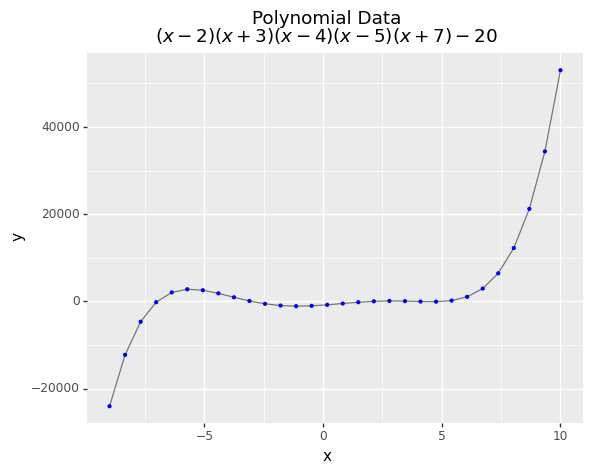

<ggplot: (99138837956)>

In [166]:
#Let us view the following polynom 
f = lambda x: (x-2)*(x+3)*(x-4)*(x-5)*(x+7)-20
f_str = r"$\left(x-2\right)\left(x+3\right)\left(x-4\right)\left(x-5\right)\left(x+7\right)-20$"

x = np.linspace(-9, 10, 30)
y = f(x)

(ggplot(DataFrame({'x':x, 'y': y}), aes(x='x', y='y')) + 
 geom_line(size=.5, alpha=0.5)+
 geom_point(color="blue", size=.7) + 
 labs(title="Polynomial Data\n" + f_str))




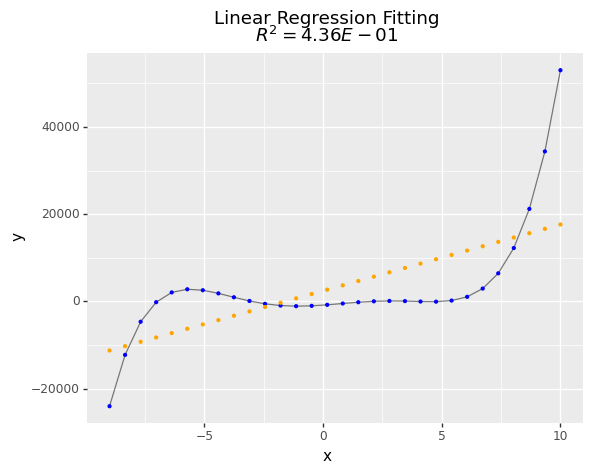

<ggplot: (99139976117)>

In [167]:
# We begin with (poorly) fitting a linear regression to the data and asses our performance:
from sklearn.linear_model import LinearRegression
X = x.reshape(-1,1)
model = LinearRegression().fit(X, y)

(ggplot(DataFrame({'x':x, 'y': y, 'y_hat': model.predict(X)}), 
        aes(x='x', y='y')) + 
 geom_line(size=.5, alpha=.5) +
 geom_point(color="blue", size=.7) + 
 geom_point(aes(x='x', y='y_hat'), color="orange", size=.7) + 
 labs(title="Linear Regression Fitting\n"+r"$R^2={:.2E}$".format(model.score(X, y))))


In [168]:
# Notice that the model we tried to use above is a simple linear regression. That is, using one explanatory
# variable (one feature) we try to find beta_0, beta_1 such that we can explain the response as: y= beta1 * x + beta0. 
# Polynomial fitting is done by taking such a setup (of one explanatory variable) and creating many "features" from it.
# Each such feature is a different degree of our explanatory variable, over which we then apply a multivariate linear 
# regression.

from sklearn.preprocessing import PolynomialFeatures
DataFrame(PolynomialFeatures(5).fit_transform(X[:5]))

,0,1,2,3,4,5
0,1.0,-9.000000,81.000000,-729.000000,6561.000000,-59049.000000
1,1.0,-8.344828,69.636147,-581.101644,4849.193031,-40465.679774
2,1.0,-7.689655,59.130797,-454.695436,3496.451115,-26886.503401
3,1.0,-7.034483,49.483948,-348.093977,2448.661078,-17225.064136
4,1.0,-6.379310,40.695600,-259.609865,1656.131898,-10564.979350


(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)
(30,)


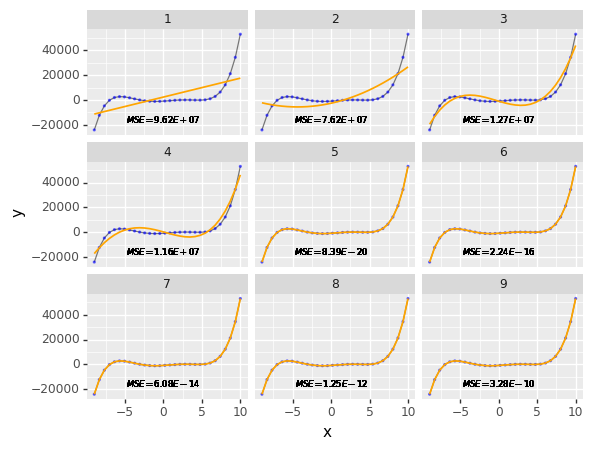

<ggplot: (99136417979)>

In [171]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

dfs = []
for k in range(1, 10):
    model = make_pipeline(PolynomialFeatures(k), LinearRegression())
    model.fit(X, y)
    y_hat = model.predict(X)
    dfs.append(DataFrame({'x':x, 'y':y, 'y_hat': y_hat,  'k': k,
                          'mse': r"$MSE={:.2E}$".format(np.mean((y-y_hat)**2))}))
dfs = pd.concat(dfs)

(ggplot(dfs, aes(x='x', y='y')) + 
 geom_line(size=.5, alpha=.5) +
 geom_point(color="blue", size=.3, alpha=.5) + 
 geom_line(aes(x='x', y='y_hat'), color="orange", size=.7) +
 geom_text(aes(label='mse'), x=0, y=-15000, size=6) +
 facet_wrap("~k"))




In [178]:

def add_noise(data, factor):
    """
    Given a set of samples add normal noise with zero mean and factor times 
    the standard deviation (of the given data) (factor*std) 
    :param data: The samples to add noise to
    :param factor: The factor to multiply the standard deviation by
    :return: An array of same size with the added normal noise
    """
    noise = np.random.normal(loc=0, scale=factor*np.std(data), size=len(data))
    return data + noise
           

def fit_poly_regression(x, y, y_noisy, k):
    """
    Fit a polynomial regression model (first create the feature matrix and then apply the regression)
    for (x, y_noisy) and return a data frame as specified below
    :param x: x values
    :param y: y values
    :param y_noisy: y values with added noise. These are the values the model actually observes and 
    that we use for fitting 
    :param k: degree pf polynom to fit
    :return: A pandas DataFrame with the exact column names: 'x', 'y', 'y_noisy', 'y_hat', 'k', 'mse'
    """
    model = make_pipeline(PolynomialFeatures(k), LinearRegression())
    model.fit(x,y_noisy)
    y_hat = model.predict(x)

    return pd.DataFrame({'x':x.flatten(),
                         'y':y,
                         'y_noisy': y_noisy,
                         'y_hat': y_hat,
                         'k': k,
                        'mse': r"$MSE={:.2E}$".format(np.mean((y-y_hat)**2))})
    


def plot_poly_fit(x, y, y_noisy, ks):
    """
    Create a ggplot showing the polynomial regression fit for different degrees
    :param x: x values
    :param y: y values
    :param y_noisy: y values with added noise. These are the values the model actually observes and 
    that we use for fitting
    :param ks: collection of degrees
    :return: A ggplot with the following:
    1) geom_line and geom_point for the original x,y. Color black
    2) geom_point for the x,y_noisy to show the actual data used for the fitting. Color red and shape 'x'
    3) geom_line for the x,y_hat to show the predictions of the polynomial regression, Color orange
    4) Add a text label on the graph (at location 0,-15000) of the mse of each fit
    5) Use `facet_wrap` to show a different graph for every value of k
    """
    dfs = []
    for k in ks:
        dfs.append(fit_poly_regression(x,y,y_noisy,k))
    dfs = pd.concat(dfs)
    
    return ggplot(dfs) + geom_line(aes(x='x', y='y'), color='black',size=.5, alpha=.5) + \
           geom_point(aes(x='x', y='y_noisy'), color='red', shape='x',size=.3, alpha=.5) + \
            geom_line(aes(x='x', y='y_hat'), color='orange', size=.7) + \
        geom_text(aes(label='mse'), x=0, y=-15000, size=6) + facet_wrap("~k")



x = np.linspace(-9, 10, 30)
X = x.reshape(-1, 1)
y = f(x)

np.random.seed(8)
y_noisy = add_noise(y, 2)
p = plot_poly_fit(X, y, y_noisy, range(1, 20))
ggsave(p, "Polynomial.Regression.Fitting1.png", dpi=300)

np.random.seed(10)
y_noisy = add_noise(y, 2)
p = plot_poly_fit(X, y, y_noisy, range(1, 20))
ggsave(p, "Polynomial.Regression.Fitting2.png", dpi=300)

C:\Users\Ron\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
C:\Users\Ron\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: Polynomial.Regression.Fitting1.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\Ron\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
C:\Users\Ron\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: Polynomial.Regression.Fitting2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
